In [88]:
import pandas as pd
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

Dataframe from MDA_merge_data.ipynb is loaded, datetime column is dropped in order to run model.

In [116]:
df = pd.read_csv("C:\\Users\Arthur\hello\\final_df.csv", delimiter=";")
#select only three locations close to Oude Markt
df = df[df['object_id']<255442]
df['255439'] = df['object_id']==255439
df['255440'] = df['object_id']==255440
df['255441'] = df['object_id']==255441
df = df.sort_values(by=['result_timestamp','object_id'])

In [117]:
df['key'] = df['object_id'].astype('str') + df['result_timestamp']
df['result_timestamp'] = pd.to_datetime(df['result_timestamp'],format='%Y-%m-%d %H:%M:%S')
df


,object_id,result_timestamp,laeq,date,time,hour,weekday,month,weekend,day_time,...,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3,255439,255440,255441,key
272166,255441,2022-01-01 00:00:00,63.267554,2022-01-01,00:00:00,0,Saturday,1,True,Saturday 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,2554412022-01-01 00:00:00
272170,255441,2022-01-01 00:10:00,60.254000,2022-01-01,00:10:00,0,Saturday,1,True,Saturday 00:10:00,...,0.04,0.0,13.28,13.28,13.223,13.23639,False,False,True,2554412022-01-01 00:10:00
272174,255441,2022-01-01 00:20:00,55.143907,2022-01-01,00:20:00,0,Saturday,1,True,Saturday 00:20:00,...,0.02,0.0,13.28,13.28,13.223,13.16699,False,False,True,2554412022-01-01 00:20:00
272178,255441,2022-01-01 00:30:00,58.230167,2022-01-01,00:30:00,0,Saturday,1,True,Saturday 00:30:00,...,0.04,0.0,13.28,13.28,13.223,13.19886,False,False,True,2554412022-01-01 00:30:00
272182,255441,2022-01-01 00:40:00,54.220466,2022-01-01,00:40:00,0,Saturday,1,True,Saturday 00:40:00,...,0.02,0.0,13.28,13.28,13.223,13.16699,False,False,True,2554412022-01-01 00:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332425,255441,2022-12-31 23:10:00,53.712833,2022-12-31,23:10:00,23,Saturday,12,True,Saturday 23:10:00,...,0.40,0.0,16.61,16.61,16.553,16.52797,False,False,True,2554412022-12-31 23:10:00
332431,255441,2022-12-31 23:20:00,55.333167,2022-12-31,23:20:00,23,Saturday,12,True,Saturday 23:20:00,...,0.29,0.0,16.61,16.61,16.553,16.57995,False,False,True,2554412022-12-31 23:20:00
332437,255441,2022-12-31 23:30:00,56.797333,2022-12-31,23:30:00,23,Saturday,12,True,Saturday 23:30:00,...,0.15,0.0,16.51,16.51,16.453,16.44846,False,False,True,2554412022-12-31 23:30:00
332443,255441,2022-12-31 23:40:00,61.010667,2022-12-31,23:40:00,23,Saturday,12,True,Saturday 23:40:00,...,0.29,0.0,16.49,16.49,16.433,16.46641,False,False,True,2554412022-12-31 23:40:00


In [119]:
df_noisedelay = df[['object_id','result_timestamp','laeq']]
df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(hours=6)
df_noisedelay


C:\Users\Arthur\AppData\Local\Temp\ipykernel_14036\2139707113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(hours=6)


,object_id,result_timestamp,laeq
272166,255441,2022-01-01 06:00:00,63.267554
272170,255441,2022-01-01 06:10:00,60.254000
272174,255441,2022-01-01 06:20:00,55.143907
272178,255441,2022-01-01 06:30:00,58.230167
272182,255441,2022-01-01 06:40:00,54.220466
...,...,...,...
332425,255441,2023-01-01 05:10:00,53.712833
332431,255441,2023-01-01 05:20:00,55.333167
332437,255441,2023-01-01 05:30:00,56.797333
332443,255441,2023-01-01 05:40:00,61.010667


In [120]:
df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
df_noisedelay['key'] = df_noisedelay['object_id'].astype('str') + df_noisedelay['result_timestamp'].astype('str')
df_noisedelay = df_noisedelay.drop(['laeq','object_id','result_timestamp'], axis=1)

df_weatherdelay = df[['object_id','result_timestamp','LC_HUMIDITY','LC_DWPTEMP','LC_n','LC_RAD','LC_RAININ',
                   'LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0']]
df_weatherdelay['result_timestamp'] = df_weatherdelay['result_timestamp']+pd.DateOffset(hours=6)

df_weatherdelay['key'] = df_weatherdelay['object_id'].astype('str') + df_weatherdelay['result_timestamp'].astype('str')
df_weatherdelay = df_weatherdelay.drop(['object_id','result_timestamp'], axis=1)
df = df.drop(['LC_HUMIDITY','LC_DWPTEMP','LC_n','LC_RAD','LC_RAININ',
                'LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0'],axis=1)


C:\Users\Arthur\AppData\Local\Temp\ipykernel_14036\180620370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
C:\Users\Arthur\AppData\Local\Temp\ipykernel_14036\180620370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['key'] = df_noisedelay['object_id'].astype('str') + df_noisedelay['result_timestamp'].astype('str')
C:\Users\Arthur\AppData\Local\Temp\ipykernel_14036\180620370.py:7: SettingWithCopyWarning: 
A value is trying to be se

In [121]:
df = pd.merge(df,df_noisedelay, on='key',validate='1:1')
df = pd.merge(df,df_weatherdelay, on='key',validate='1:1')

In [122]:
df_night = df.set_index('result_timestamp')
df_night = df_night.between_time(start_time='22:00:00', end_time='6:00:00', inclusive='left')
df_night = df_night.reset_index()


In [123]:
df_night['hour'].replace(to_replace=[22,23,0,1,2,3,4,5], value=[0,1,2,3,4,5,6,7], inplace=True)
df_night

,result_timestamp,object_id,laeq,date,time,hour,weekday,month,weekend,day_time,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
0,2022-01-01 22:00:00,255441,53.217333,2022-01-01,22:00:00,0,Saturday,1,True,Saturday 22:00:00,...,85.0,11.26,37.0,0.0,0.0,0.000,25.0,0.14,13.0,13.76
1,2022-01-01 22:10:00,255441,49.338500,2022-01-01,22:10:00,0,Saturday,1,True,Saturday 22:10:00,...,85.0,11.18,38.0,0.0,0.0,0.000,-68.0,0.09,7.0,13.68
2,2022-01-01 22:20:00,255441,47.848000,2022-01-01,22:20:00,0,Saturday,1,True,Saturday 22:20:00,...,85.0,11.05,37.0,0.0,0.0,0.000,-107.0,0.13,4.0,13.55
3,2022-01-01 22:30:00,255441,51.391333,2022-01-01,22:30:00,0,Saturday,1,True,Saturday 22:30:00,...,85.0,10.98,38.0,0.0,0.0,0.000,30.0,0.10,1.0,13.50
4,2022-01-01 22:40:00,255441,48.810500,2022-01-01,22:40:00,0,Saturday,1,True,Saturday 22:40:00,...,84.0,10.83,37.0,0.0,0.0,0.000,24.0,0.07,0.0,13.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43827,2022-12-31 23:10:00,255441,53.712833,2022-12-31,23:10:00,1,Saturday,12,True,Saturday 23:10:00,...,65.0,9.48,38.0,0.0,0.0,0.001,-28.0,0.17,0.0,15.95
43828,2022-12-31 23:20:00,255441,55.333167,2022-12-31,23:20:00,1,Saturday,12,True,Saturday 23:20:00,...,66.0,9.50,37.0,0.0,0.0,0.001,38.0,0.31,0.0,15.89
43829,2022-12-31 23:30:00,255441,56.797333,2022-12-31,23:30:00,1,Saturday,12,True,Saturday 23:30:00,...,66.0,9.43,38.0,0.0,0.0,0.001,46.0,0.26,0.0,15.79
43830,2022-12-31 23:40:00,255441,61.010667,2022-12-31,23:40:00,1,Saturday,12,True,Saturday 23:40:00,...,65.0,9.19,37.0,0.0,0.0,0.001,10.0,0.39,0.0,15.78


In [126]:
df_nd = df_night.drop(['key','object_id','result_timestamp','date','time','day_time','day_hour','LC_TEMP_QCL1','LC_TEMP_QCL2','LC_TEMP_QCL3'], axis=1)

In [127]:
df_nd

,laeq,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
0,53.217333,0,Saturday,1,True,True,False,False,False,True,...,85.0,11.26,37.0,0.0,0.0,0.000,25.0,0.14,13.0,13.76
1,49.338500,0,Saturday,1,True,True,False,False,False,True,...,85.0,11.18,38.0,0.0,0.0,0.000,-68.0,0.09,7.0,13.68
2,47.848000,0,Saturday,1,True,True,False,False,False,True,...,85.0,11.05,37.0,0.0,0.0,0.000,-107.0,0.13,4.0,13.55
3,51.391333,0,Saturday,1,True,True,False,False,False,True,...,85.0,10.98,38.0,0.0,0.0,0.000,30.0,0.10,1.0,13.50
4,48.810500,0,Saturday,1,True,True,False,False,False,True,...,84.0,10.83,37.0,0.0,0.0,0.000,24.0,0.07,0.0,13.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43827,53.712833,1,Saturday,12,True,True,False,False,False,True,...,65.0,9.48,38.0,0.0,0.0,0.001,-28.0,0.17,0.0,15.95
43828,55.333167,1,Saturday,12,True,True,False,False,False,True,...,66.0,9.50,37.0,0.0,0.0,0.001,38.0,0.31,0.0,15.89
43829,56.797333,1,Saturday,12,True,True,False,False,False,True,...,66.0,9.43,38.0,0.0,0.0,0.001,46.0,0.26,0.0,15.79
43830,61.010667,1,Saturday,12,True,True,False,False,False,True,...,65.0,9.19,37.0,0.0,0.0,0.001,10.0,0.39,0.0,15.78


In [128]:
df_nd.isna().sum()


laeq             0
hour             0
weekday          0
month            0
weekend          0
holiday          0
exam_period      0
255439           0
255440           0
255441           0
laeq_delayed     0
LC_HUMIDITY     15
LC_DWPTEMP      15
LC_n            15
LC_RAD          15
LC_RAININ       15
LC_DAILYRAIN    15
LC_WINDDIR      15
LC_WINDSPEED    15
LC_RAD60         0
LC_TEMP_QCL0    15
dtype: int64

In [129]:
df_nd = df_nd[df_nd.isna()['LC_HUMIDITY']==False]
df_nd.isna().sum()

laeq            0
hour            0
weekday         0
month           0
weekend         0
holiday         0
exam_period     0
255439          0
255440          0
255441          0
laeq_delayed    0
LC_HUMIDITY     0
LC_DWPTEMP      0
LC_n            0
LC_RAD          0
LC_RAININ       0
LC_DAILYRAIN    0
LC_WINDDIR      0
LC_WINDSPEED    0
LC_RAD60        0
LC_TEMP_QCL0    0
dtype: int64

In [130]:
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Monday', value=0)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Tuesday', value=1)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Wednesday', value=2)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Thursday', value=3)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Friday', value=4)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Saturday', value=5)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Sunday', value=6)

C:\Users\Arthur\AppData\Local\Temp\ipykernel_14036\2591902735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Monday', value=0)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_14036\2591902735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Tuesday', value=1)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_14036\2591902735.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

The target dataset (y) and predictor dataset (X) are created. For y, noise is converted to relative noise (proportion of max value)

In [131]:
df_nd

,laeq,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
0,53.217333,0,5,1,True,True,False,False,False,True,...,85.0,11.26,37.0,0.0,0.0,0.000,25.0,0.14,13.0,13.76
1,49.338500,0,5,1,True,True,False,False,False,True,...,85.0,11.18,38.0,0.0,0.0,0.000,-68.0,0.09,7.0,13.68
2,47.848000,0,5,1,True,True,False,False,False,True,...,85.0,11.05,37.0,0.0,0.0,0.000,-107.0,0.13,4.0,13.55
3,51.391333,0,5,1,True,True,False,False,False,True,...,85.0,10.98,38.0,0.0,0.0,0.000,30.0,0.10,1.0,13.50
4,48.810500,0,5,1,True,True,False,False,False,True,...,84.0,10.83,37.0,0.0,0.0,0.000,24.0,0.07,0.0,13.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43827,53.712833,1,5,12,True,True,False,False,False,True,...,65.0,9.48,38.0,0.0,0.0,0.001,-28.0,0.17,0.0,15.95
43828,55.333167,1,5,12,True,True,False,False,False,True,...,66.0,9.50,37.0,0.0,0.0,0.001,38.0,0.31,0.0,15.89
43829,56.797333,1,5,12,True,True,False,False,False,True,...,66.0,9.43,38.0,0.0,0.0,0.001,46.0,0.26,0.0,15.79
43830,61.010667,1,5,12,True,True,False,False,False,True,...,65.0,9.19,37.0,0.0,0.0,0.001,10.0,0.39,0.0,15.78


In [146]:
y = df_nd["laeq"]
X = df_nd.drop(["laeq"], axis="columns")

In [163]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=4320,
    max_train_size=8760,
    test_size=6147,
)

In [164]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,laeq_delayed,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
2,0,5,1,True,True,False,False,False,True,52.115167,85.0,11.05,37.0,0.0,0.0,0.0,-107.0,0.13,4.0,13.55
3,0,5,1,True,True,False,False,False,True,52.228667,85.0,10.98,38.0,0.0,0.0,0.0,30.0,0.10,1.0,13.50
4,0,5,1,True,True,False,False,False,True,52.135500,84.0,10.83,37.0,0.0,0.0,0.0,24.0,0.07,0.0,13.39
5,0,5,1,True,True,False,False,False,True,52.291833,85.0,10.92,38.0,0.0,0.0,0.0,-54.0,0.04,0.0,13.33
6,1,5,1,True,True,False,False,False,True,53.002500,86.0,10.90,37.0,0.0,0.0,0.0,-92.0,0.03,0.0,13.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8757,5,0,4,False,True,False,True,False,False,50.913833,59.0,1.29,36.0,0.0,0.0,0.0,101.0,0.23,0.0,8.90
8758,5,0,4,False,True,False,False,True,False,50.849667,59.0,1.29,36.0,0.0,0.0,0.0,101.0,0.23,0.0,8.90
8759,5,0,4,False,True,False,False,False,True,51.662333,59.0,1.29,36.0,0.0,0.0,0.0,101.0,0.23,0.0,8.90
8760,5,0,4,False,True,False,True,False,False,49.754333,60.0,1.55,36.0,0.0,0.0,0.0,104.0,0.21,0.0,8.85


In [165]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,laeq_delayed,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
24590,0,5,7,True,True,False,False,True,False,52.469833,39.0,11.95,31.0,128.0,0.0,0.0,-50.0,0.05,164.0,27.22
24591,0,5,7,True,True,False,False,False,True,52.732833,39.0,11.95,31.0,128.0,0.0,0.0,-50.0,0.05,164.0,27.22
24592,0,5,7,True,True,False,True,False,False,50.522333,39.0,12.03,32.0,145.0,0.0,0.0,-45.0,0.17,172.0,27.22
24593,0,5,7,True,True,False,False,True,False,49.932167,39.0,12.03,32.0,145.0,0.0,0.0,-45.0,0.17,172.0,27.22
24594,0,5,7,True,True,False,False,False,True,51.132167,39.0,12.03,32.0,145.0,0.0,0.0,-45.0,0.17,172.0,27.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33354,7,3,9,False,False,False,False,False,True,57.521500,94.0,6.46,32.0,0.0,0.0,0.0,0.0,0.00,0.0,7.32
33355,7,3,9,False,False,False,True,False,False,56.063333,94.0,6.37,31.0,0.0,0.0,0.0,-112.0,0.00,0.0,7.26
33356,7,3,9,False,False,False,False,True,False,50.710000,94.0,6.37,31.0,0.0,0.0,0.0,-112.0,0.00,0.0,7.26
33357,7,3,9,False,False,False,False,False,True,54.279833,94.0,6.37,31.0,0.0,0.0,0.0,-112.0,0.00,0.0,7.26


In [178]:
# grid search for hyperparameter tuning

param_grid = {
    'learning_rate': (0.05,0.06,0.07),
    'n_estimators': (60,70,80),
    'max_depth' : (2,3,4)}
model = xgb.XGBRegressor()
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=ts_cv)
model_grid_search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=4320, max_train_size=8760, n_splits=5, test_size=6147),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None,...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=2,
             param_grid={'learning_rate': (0.05, 0.06, 0.07),
                         'max_depth': (2, 3, 4), 'n_estimators': (50, 60, 70)})

In [179]:
accuracy = model_grid_search.score(X, y)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.62


In [180]:
model_grid_search.predict(X.iloc[0:5])

array([51.42821, 51.28905, 51.42821, 51.42821, 51.42821], dtype=float32)

In [182]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 70}


In [183]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.320752,0.004849,0.021843,0.001015,0.06,3,70,"{'learning_rate': 0.06, 'max_depth': 3, 'n_est...",0.340215,0.602331,0.628658,-0.673473,-0.167956,0.145955,0.499804,1
13,0.283076,0.004361,0.021944,0.001410,0.06,3,60,"{'learning_rate': 0.06, 'max_depth': 3, 'n_est...",0.370973,0.609616,0.613449,-0.887738,-0.017832,0.137694,0.561992,2
22,0.366068,0.006768,0.026440,0.001304,0.07,3,60,"{'learning_rate': 0.07, 'max_depth': 3, 'n_est...",0.340696,0.587634,0.627976,-0.718752,-0.165817,0.134347,0.511780,3
21,0.320089,0.006026,0.029327,0.002129,0.07,3,50,"{'learning_rate': 0.07, 'max_depth': 3, 'n_est...",0.377073,0.600374,0.603904,-0.947189,0.018745,0.130581,0.579585,4
23,0.409195,0.004640,0.026930,0.003026,0.07,3,70,"{'learning_rate': 0.07, 'max_depth': 3, 'n_est...",0.318146,0.574775,0.631166,-0.620115,-0.266453,0.127504,0.490756,5


In [184]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [185]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,param_learning_rate,param_n_estimators,param_max_depth,mean_test_score,std_test_score,rank_test_score
14,0.06,70,3,0.145955,0.499804,1
13,0.06,60,3,0.137694,0.561992,2
22,0.07,60,3,0.134347,0.511780,3
21,0.07,50,3,0.130581,0.579585,4
23,0.07,70,3,0.127504,0.490756,5
5,0.05,70,3,0.121979,0.593903,6
24,0.07,50,4,0.116928,0.588628,7
8,0.05,70,4,0.115886,0.589411,8
11,0.06,70,2,0.114702,0.505578,9
10,0.06,60,2,0.112078,0.569728,10


In [186]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_max_depth"],
    columns=["param_n_estimators"])

pivoted_cv_results

param_n_estimators,50,60,70
param_max_depth,,,
2,-0.014834,0.086765,0.104291
3,0.019384,0.112643,0.131812
4,0.006075,0.094306,0.105403


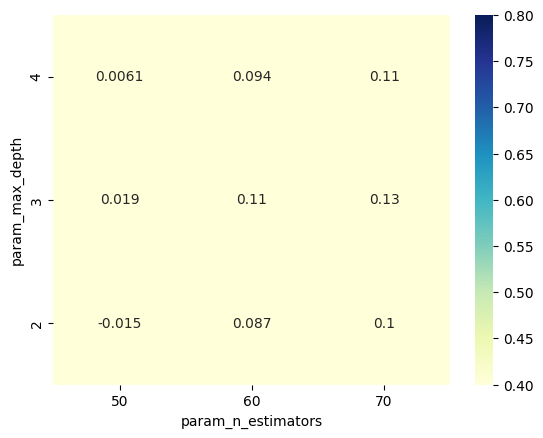

In [187]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.4,
                 vmax=0.8)
ax.invert_yaxis()

In [188]:
#run XGBoost model
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

gbrt_pipeline = xgb.XGBRegressor(learning_rate=0.06,n_estimators=70,max_depth=3)

evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     3.777 +/- 1.387
Root Mean Squared Error: 4.995 +/- 1.859


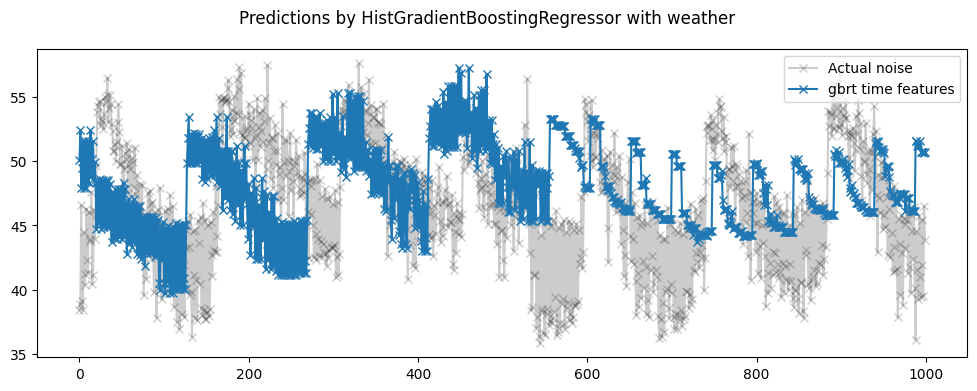

In [192]:
#Qualitative analysis of the impact of features on linear model predictions
gbrt_pipeline.fit(X, y)
gbrt_predictions = gbrt_pipeline.predict(X)

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by HistGradientBoostingRegressor with weather")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(gbrt_predictions[last_hours], "x-", label="gbrt time features")
_ = ax.legend()


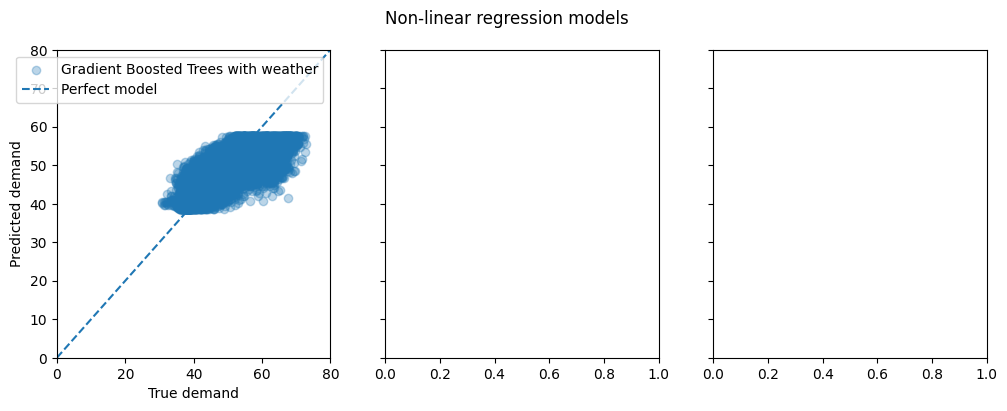

In [190]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    gbrt_predictions,
]
labels = [
    "Gradient Boosted Trees with weather",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True demand",
        ylabel="Predicted demand",
    )
    ax.legend()

plt.show()

In [193]:
predictions = gbrt_pipeline.predict(X)
MAE = sum(((predictions-y)**2)**(1/2))/len(y)
print(MAE)
RMSE = (sum((predictions-y)**2)/len(y))**(1/2)
print(RMSE)

2.60893782376488
3.6850199539680704


In [ ]:
#full XGB model:
# MAE = 2.23
# RMSE = 3.20